
Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - loss: 0.3597 - val_loss: 0.0152
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0031 - val_loss: 0.0151
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0024 - val_loss: 0.0124
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0023 - val_loss: 0.0072
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0028 - val_loss: 0.0150
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0025 - val_loss: 0.0125
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0022 - val_loss: 0.0137
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0022 - val_loss: 0.0167
Epoch 9/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0023 - val_loss: 0.0090
Epoch 10/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0022 - val_loss: 0.0082
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


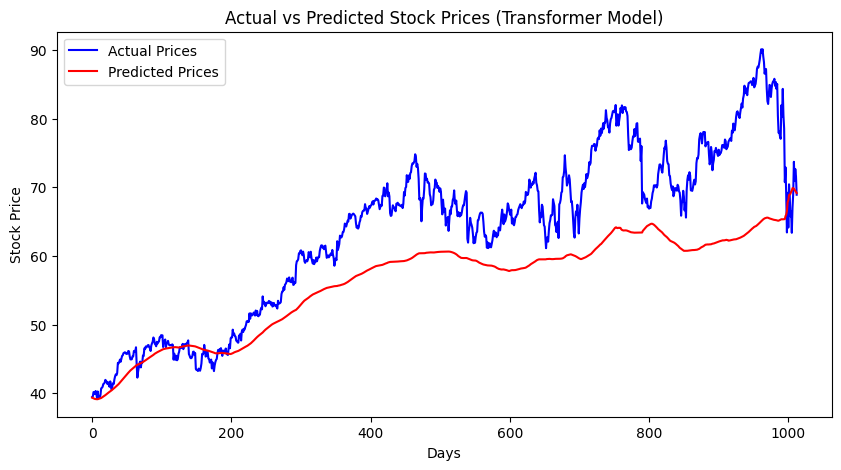

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load stock dataset from CSV
file_path = "Data.csv"  
data_df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# Ensure 'Close' column exists
data = data_df['Close'].dropna().values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Create sequences for time series forecasting
sequence_length = 60  # Use last 60 days to predict next day
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, sequence_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Transformer Model
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define Transformer-based Model
def build_transformer_model(input_shape, embed_dim=64, num_heads=2, ff_dim=128):
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(embed_dim)(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x, training=True)  # Pass training explicitly
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1)(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build and train model
input_shape = (sequence_length, 1)
model = build_transformer_model(input_shape)

epochs = 10
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

# Make predictions
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted prices
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual Prices', color='blue')
plt.plot(y_pred_inv, label='Predicted Prices', color='red')
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Actual vs Predicted Stock Prices (Transformer Model)")
plt.show()